Epoch 1/10


2024-05-28 00:35:25.734879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-28 00:35:25.908756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    7/28716 [..............................] - ETA: 4:20 - loss: 0.5099 - accuracy: 0.6228    

2024-05-28 00:35:26.661206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28716/28716 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9397

2024-05-28 00:39:06.843471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-28 00:39:06.901101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28716/28716 [==============================] - 247s 9ms/step - loss: 0.1230 - accuracy: 0.9397 - val_loss: 0.1684 - val_accuracy: 0.9344
Epoch 2/10
28716/28716 [==============================] - 248s 9ms/step - loss: 0.0801 - accuracy: 0.9607 - val_loss: 0.1594 - val_accuracy: 0.9399
Epoch 3/10
28716/28716 [==============================] - 247s 9ms/step - loss: 0.0704 - accuracy: 0.9657 - val_loss: 0.1454 - val_accuracy: 0.9454
Epoch 4/10
28716/28716 [==============================] - 247s 9ms/step - loss: 0.0646 - accuracy: 0.9687 - val_loss: 0.1515 - val_accuracy: 0.9437
Epoch 5/10
28716/28716 [==============================] - 246s 9ms/step - loss: 0.0607 - accuracy: 0.9707 - val_loss: 0.1425 - val_accuracy: 0.9480
Epoch 6/10
28716/28716 [==============================] - 247s 9ms/step - loss: 0.0573 - accuracy: 0.9726 - val_loss: 0.1306 - val_accuracy: 0.9547
Epoch 7/10
28716/28716 [==============================] - 23812s 829ms/step - loss: 0.0549 - accuracy: 0.9737 - val_loss: 0

2024-05-28 07:49:20.124724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-28 07:49:20.172448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68518/68518 [==============================] - 307s 4ms/step - loss: 0.0678 - accuracy: 0.9763
Test Loss: 0.0678
Test Accuracy: 97.63%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   2181515
           1       0.16      0.87      0.27     11060

    accuracy                           0.98   2192575
   macro avg       0.58      0.93      0.63   2192575
weighted avg       1.00      0.98      0.98   2192575



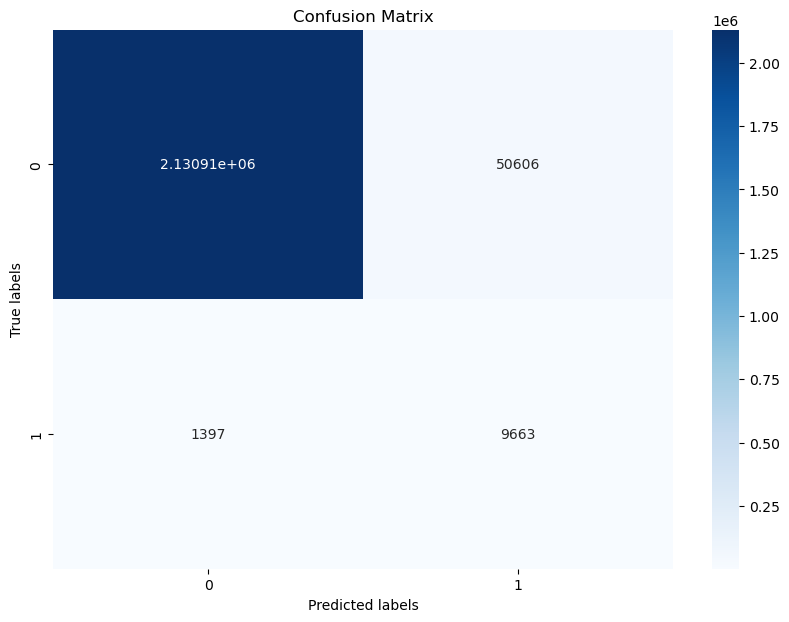

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
trainfiles = [
    'Data/29_tracks_labeled.csv', 'Data/28_tracks_labeled.csv', 'Data/27_tracks_labeled.csv', 
    'Data/22_tracks_labeled.csv', 'Data/21_tracks_labeled.csv'
]
testfiles = [
    'Data/26_tracks_labeled.csv', 'Data/25_tracks_labeled.csv', 'Data/20_tracks_labeled.csv'
]
train_data = pd.concat([pd.read_csv(file) for file in trainfiles], ignore_index=True)
test_data = pd.concat([pd.read_csv(file) for file in testfiles], ignore_index=True)

# Assuming the datasets have been properly labeled and contain the 'stopped_before_pedestrian' column
features_cols = ['xCenter', 'yCenter', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'latAcceleration']

# Split features and labels for training data
X_train = train_data[features_cols]
y_train = train_data['stopped_before_pedestrian']

# Split features and labels for testing data
X_test = test_data[features_cols]
y_test = test_data['stopped_before_pedestrian']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Reshape data for LSTM: [samples, time_steps, features]
time_steps = 1  # Since we are not using TimeDistributed, we set time_steps to 1
X_train = X_train.reshape((X_train.shape[0], time_steps, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], time_steps, X_test.shape[1]))

# Train/validation split from training data
train_val_split = int(0.8 * len(X_train))
X_train_final = X_train[:train_val_split]
X_val = X_train[train_val_split:]
y_train_final = y_train[:train_val_split]
y_val = y_train[train_val_split:]

# Build the simplified LSTM model
model = Sequential([
    LSTM(50, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=128, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Print final accuracy and classification report
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

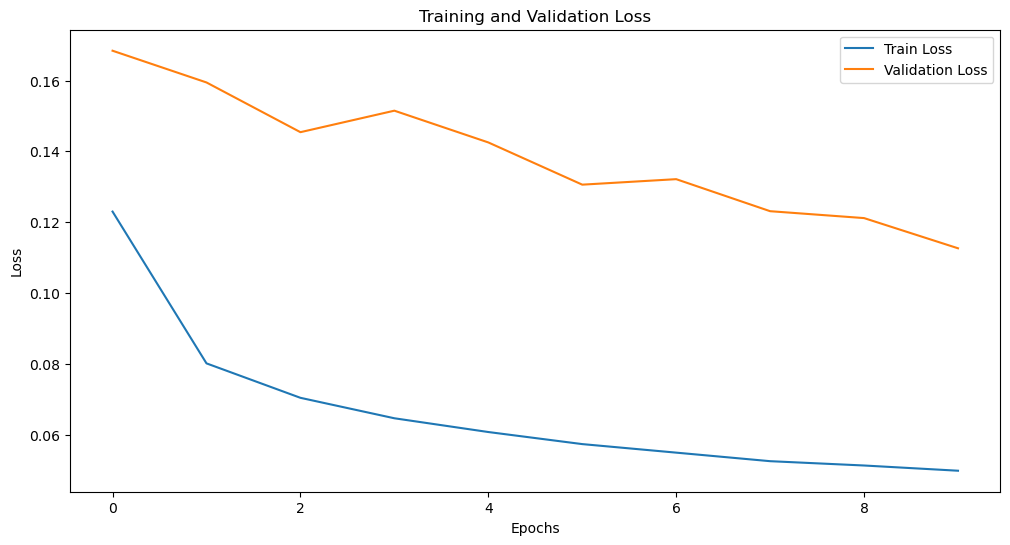

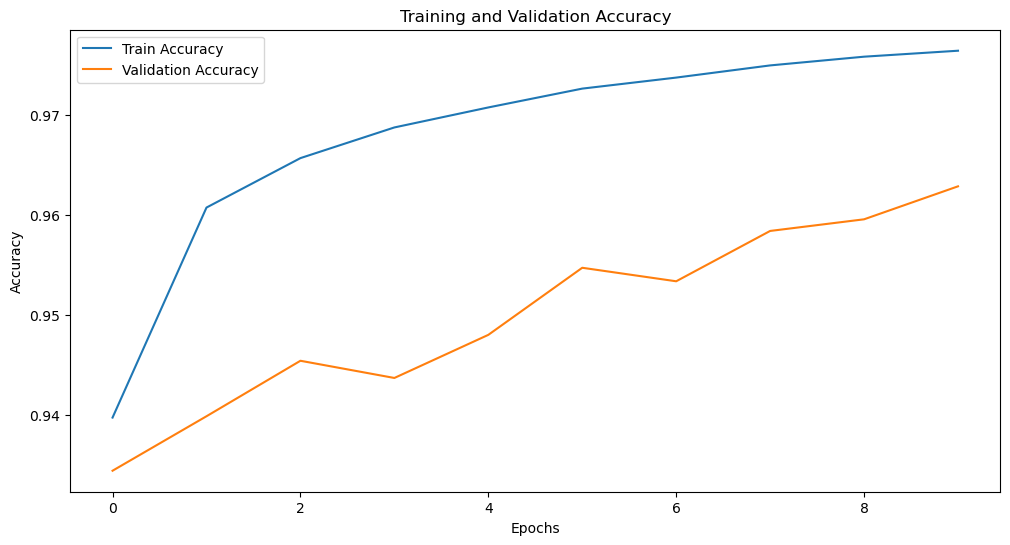

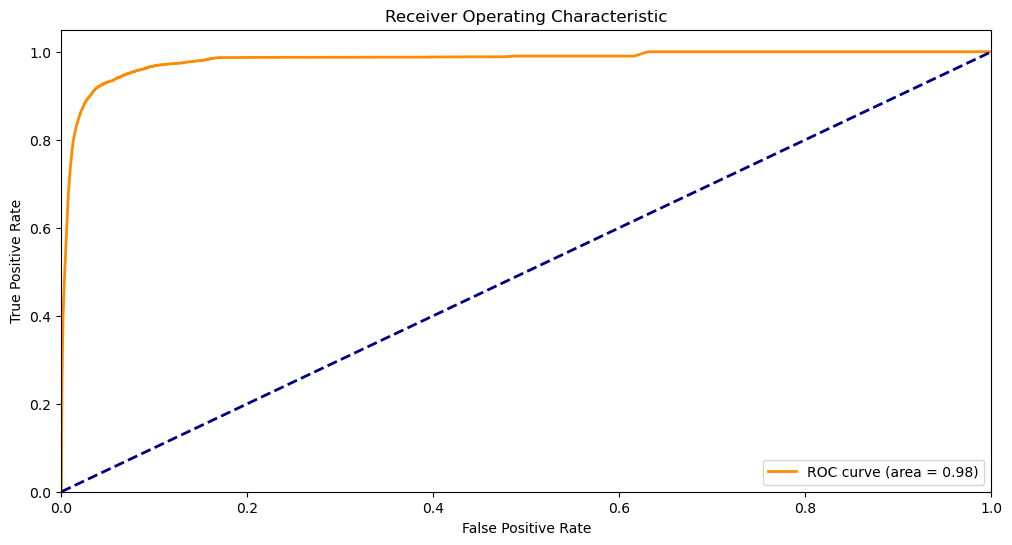

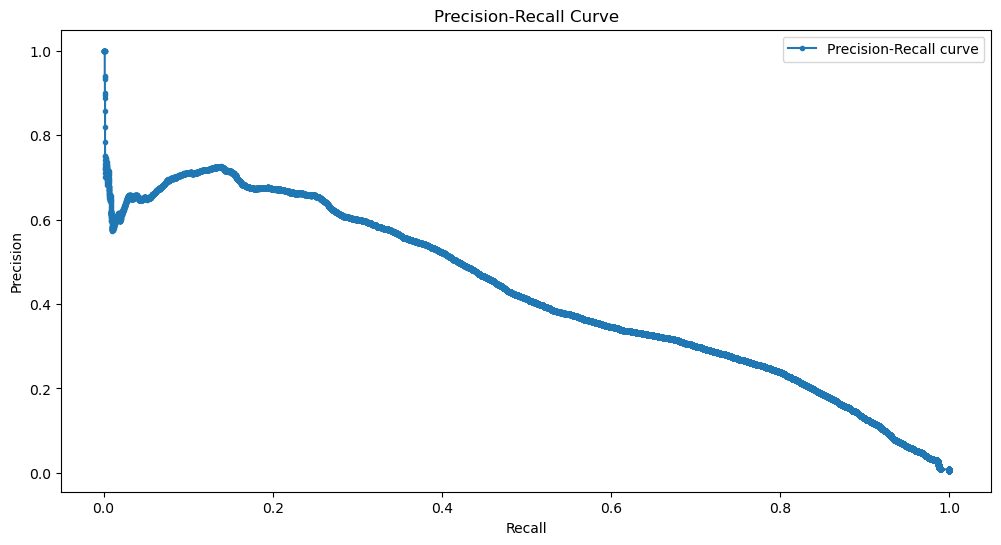

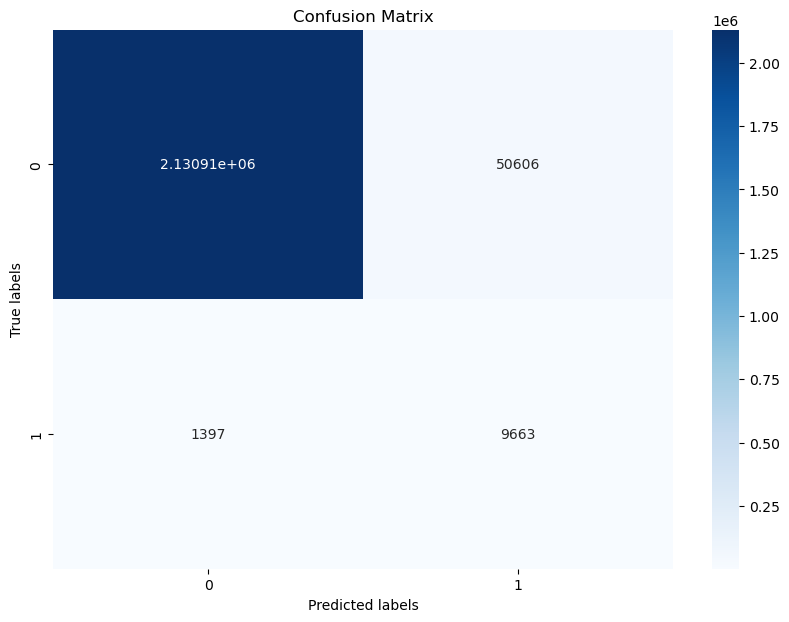

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   2181515
           1       0.16      0.87      0.27     11060

    accuracy                           0.98   2192575
   macro avg       0.58      0.93      0.63   2192575
weighted avg       1.00      0.98      0.98   2192575

ROC AUC: 0.9814


: 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

# Display ROC AUC
print(f"ROC AUC: {roc_auc:.4f}")

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print final accuracy and classification report
final_accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(classification_report(y_test, y_pred_classes))

# Plot training loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.epoch, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(history.epoch, history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()